# Face Mask Detection

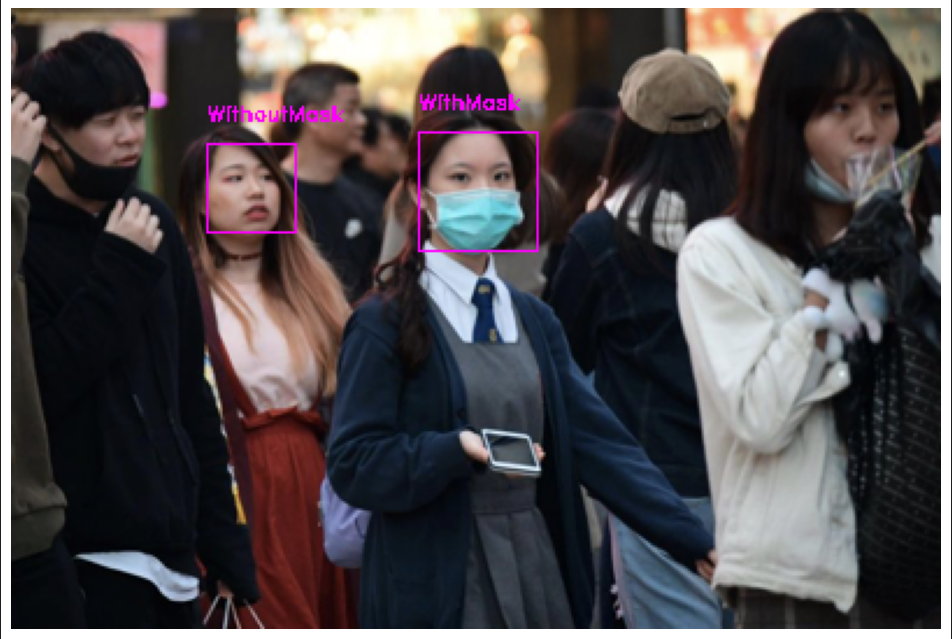


## 1. Introduction
**Context**
This dataset is used for Face Mask Detection Classification with images. The dataset consists of almost 12K images which are almost 328.92MB in size.

**Acknowledgments**
All the images with the face mask (~6K) are scrapped from google search and all the images without the face mask are preprocessed from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530). Thank you so much Jessica for providing a wonderful dataset to the community.

**Inspiration**
The inspiration behind creating this dataset is to create an algorithm that can directly detect is a person is wearing a face mask or not. So I've scrapped the images from google as well as from the CelebFace dataset created by Jessica Li (https://www.kaggle.com/jessicali9530) to make this happen.




The dataset is donwloaded from kaggle [Face Mask Detection ~12K Images Dataset](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset)

## 2. Planning
1. Data Augmentation to increase dataset size
2. Develop and train CNN model to detect face
3. Label faces
    1. Using Haarcascade find and crop faces
    2. using CNN model to predict the result
    3. label the faces with predicted result


In [ ]:
import logging
import os

# ignore all the warning and debug information from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger('tensorflow').setLevel(logging.ERROR)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix
from libs.nn.conv import CnnModel
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.optimizers import SGD, Adam
from libs.preprocessing import ImageToArrayPreprocessor
from libs.preprocessing import SimplePreprocessor
from libs.datasets import SimpleDatasetLoader
import pathlib
import matplotlib.pyplot as plt
from libs.utils.myplot import plot_confusion_matrix
import matplotlib.image as img
import opendatasets as od
import numpy as np
from imutils import paths
import os

In [ ]:
# Download the dataset
dataset_url = 'https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset'

# Look into the data directory
images_dir = './face-mask-12k-images-dataset/Face Mask Dataset'

images_dir_path = pathlib.Path(images_dir)
if not os.path.isdir(images_dir):
    od.download(dataset_url)


## 3. Data Exploration

In [ ]:
# Show random images
train_dir = f'{images_dir}/Train'
test_dir = f'{images_dir}/Test'
valid_dir = f'{images_dir}/Validation'

train_imgs = list(paths.list_images(train_dir))
test_imgs = list(paths.list_images(test_dir))
valid_imgs = list(paths.list_images(valid_dir))

len(train_imgs) + len(test_imgs) + len(valid_imgs)

In [ ]:
random_num_array = np.random.randint(len(train_imgs), size=16)
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(12, 8))

for ax, num in zip(axs.ravel(), random_num_array):
    _img = img.imread(train_imgs[num])
    ax.set_title(f'{_img.shape}')
    ax.imshow(_img, interpolation='none')
    ax.axis("off")
# plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

Observation:
* we have have total 11792 different kind of colored images with different sizes

In [ ]:
total_with_mask = len(list(paths.list_images(f'{images_dir}/Train/WithMask')))
total_without_mask = len(list(paths.list_images(f'{images_dir}/Train/WithoutMask')))
total_with_mask, total_without_mask

## 4. Data Preparation

In [ ]:
BATCH_SIZE = 32
IMG_WIDTH = IMG_HEIGHT = 96

### Loading Dataset

In [ ]:
# initialize the image preprocessor
sp = SimplePreprocessor(IMG_WIDTH, IMG_HEIGHT)
iap = ImageToArrayPreprocessor()

# load the dataset from disk 
sdl = SimpleDatasetLoader(preprocessor=[sp, iap])

X_train, Y_train = sdl.load(train_imgs, verbose=500)
X_valid, Y_valid = sdl.load(valid_imgs, verbose=500)
X_test, Y_test = sdl.load(test_imgs, verbose=500)

### Normalization

In [ ]:
# scale the raw pixel intensities to the range [0,1]
X_train = X_train.astype("float") / 255.0
X_valid = X_valid.astype("float") / 255.0
X_test = X_test.astype("float") / 255.0

In [ ]:
np.min(X_train), np.max(X_train)

### Randomize the dataset

In [ ]:
from sklearn.utils import shuffle

X_train, Y_train = shuffle(X_train, Y_train, random_state=42)
X_valid, Y_valid = shuffle(X_valid, Y_valid, random_state=42)

### Convert label to Vectors

In [ ]:
Y_train[:5]

In [ ]:
# convert the labels from integers to vectors
label_bin = LabelBinarizer()
Y_train = label_bin.fit_transform(Y_train)
Y_valid = label_bin.transform(Y_valid)
Y_test = label_bin.transform(Y_test)

In [ ]:
Y_train[:5]

In [ ]:
class_names_list = label_bin.classes_

## 4. Training CNN Model

In [ ]:
cnn_model = CnnModel.build(width=IMG_WIDTH, height=IMG_HEIGHT, depth=3, classes=1)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [ ]:
opt = SGD(learning_rate=0.005)
cnn_model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy", 'Recall', 'Precision', 'AUC'])

In [ ]:
class MyEarlyStoppingCb(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('accuracy') > 0.99):
            print(r'\n Reached 99% accuracy, Stopping the training...')
            self.model.stop_training = True

In [ ]:
my_early_stopping_cb = MyEarlyStoppingCb()
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)

In [ ]:
history = cnn_model.fit(X_train, Y_train,
                        validation_data=(X_valid, Y_valid),
                        batch_size=BATCH_SIZE,
                        epochs=20,
                        callbacks=[my_early_stopping_cb, early_stopping_cb])

In [ ]:
cnn_model.summary()

## 5. Model Evaluation

In [ ]:
# plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
model_loss, model_acc, recall, precision, auc = cnn_model.evaluate(X_test, Y_test)
print(
    f'model_loss: {model_loss}, model_acc: {model_acc * 100}, recall: {recall * 100}, precision:{precision * 100}, auc:{auc * 100}')

In [ ]:
preds = cnn_model.predict(X_test, batch_size=BATCH_SIZE)
preds[preds >= 0.5] = 1
preds[preds < 0.5] = 0
preds = preds.flatten()

In [ ]:
print(classification_report(Y_test, preds, target_names=class_names_list))

In [ ]:
plot_confusion_matrix(Y_test, preds, class_names_list, 'Test')

## 6 Save the trained model

In [ ]:
saved_model_path = 'model/face_mask_detection.h5'

In [ ]:
cnn_model.save(saved_model_path)

In [ ]:
import cv2

In [ ]:
test_image = '1.png'  #'real-test1.png'
face_detection_haarcascade_file = 'libs/haarcascade/haarcascade_frontalface_default.xml'

In [ ]:
cascade_clf = cv2.CascadeClassifier(face_detection_haarcascade_file)
img = cv2.imread(test_image)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# returns a list of (x,y,w,h) tuples
detected_faces = cascade_clf.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=4)
detected_faces

In [ ]:
# Image plotting

for (x, y, w, h) in detected_faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 1)

    cropped_face = img[y + 10:y + h + 15, x + 15:x + w + 15]

    # scaling
    cropped_face = cv2.resize(cropped_face, (IMG_HEIGHT, IMG_WIDTH))
    cropped_face = np.reshape(cropped_face, [1, IMG_HEIGHT, IMG_WIDTH, 3]) / 255.0
    prediction = cnn_model.predict(cropped_face)
    print(get_label(prediction))

output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(12, 12))
plt.imshow(output_img)
plt.axis('off')

In [ ]:
# Image plotting

for (x, y, w, h) in detected_faces:
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 1)

    # predict
    cropped_face = img[y:y + h, x:x + w]
    cropped_face = cv2.resize(cropped_face, (IMG_HEIGHT, IMG_WIDTH))
    cropped_face = np.reshape(cropped_face, [1, IMG_HEIGHT, IMG_WIDTH, 3])  # / 255.0

    prediction = cnn_model.predict(cropped_face)
    print(get_label(prediction))

output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.figure(figsize=(12, 12))
plt.imshow(output_img)
plt.axis('off')

## 7. Future Work

## 8. Reference